<a href="https://colab.research.google.com/github/JoshuaChung93/Cryptocurrency-trading-bot/blob/Backtest/BTC_IBS_strategy_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BTC historical dataset/BTC-Hourly.csv', index_col=0)

In [ ]:
# 시계열에 맞게 인덱스를 거꾸로 돌려줍니다
df = df.loc[::-1].reset_index(drop=True)
df.head()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [ ]:
# 인덱스 이름 설정
df.index.name = 'Bar numbers'
# 필요 없는 열 드랍하기
df.drop(['Volume BTC','Volume USD'], axis=1, inplace=True)
df.tail()

,date,symbol,open,high,low,close
Bar numbers,,,,,,
33254,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97
33255,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53
33256,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32
33257,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98
33258,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27


In [ ]:
import copy

df1 = copy.deepcopy(df)
df = df1.copy()

## Plot the backtest period

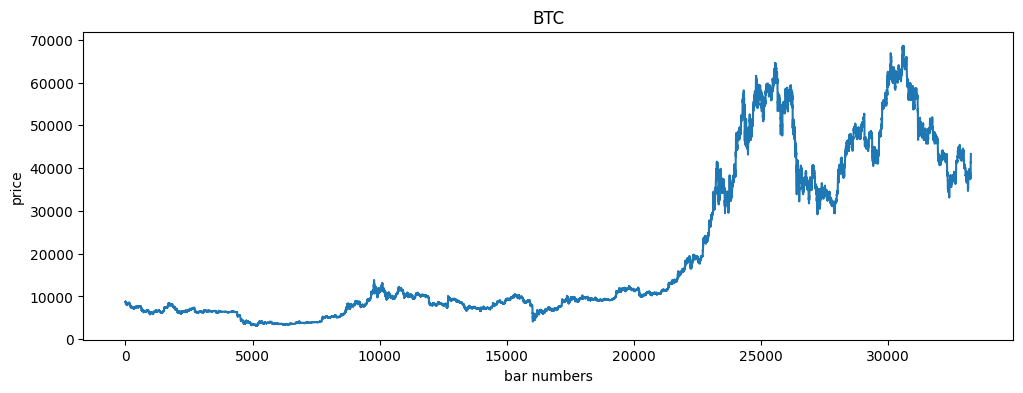

In [ ]:
plt.style.use(['default'])
df['close'].plot(figsize=(12,4), title='BTC')
plt.xlabel('bar numbers')
plt.ylabel('price')

plt.show()

In [ ]:
# 100SMA, 200SMA 칼럼 생성
df['200SMA'] = df['close'].rolling(4800).mean()
df['100SMA'] = df['close'].rolling(2400).mean()
df.head()

,date,symbol,open,high,low,close,200SMA,100SMA
Bar numbers,,,,,,,,
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,NaN,NaN
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,NaN,NaN
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,NaN,NaN
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,NaN,NaN
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,NaN,NaN


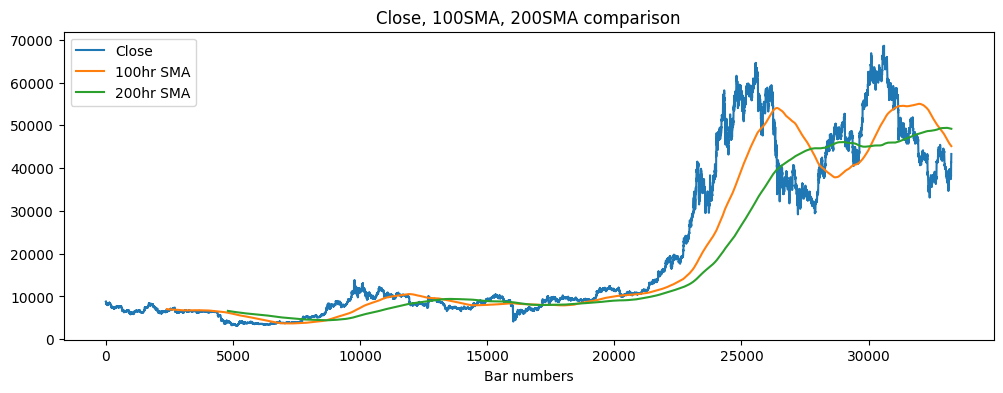

In [ ]:
df['close'].plot(figsize=(12,4), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

plt.title('Close, 100SMA, 200SMA comparison')
plt.legend()


# make signal column

In [ ]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
df['long_con'] = (df['close']) <= (1.05*df['100SMA'])
df['short_con'] = (df['close']) >= (0.95*df['100SMA'])

In [ ]:
# long 진입청산 컬럼 생성
df['entry_long'] = np.where((df['long']==True)&(df['long_con']==True), 1.0,0.0) # 진입신호
df['exit_long'] = np.where(df['short']==True, 1.0,0.0) # 청산신호

In [ ]:
# 포지션 보유 여부 컬럼 생성
df['position'] = df['entry_long'] - df['exit_long']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position"]):
    if lastseen == 0 and el == -1:
        df.loc[n,'position'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position"] = 0
# # deal with edge case
# df.loc[7,'position'] = 0

In [ ]:
df.loc[(df.position==1)|(df.position==-1),:]

,date,symbol,open,high,low,close,200SMA,100SMA,long,short,long_con,short_con,entry_long,exit_long,position
Bar numbers,,,,,,,,,,,,,,,
2408,2018-08-23 14:00:00,BTC/USD,6426.14,6495.00,6426.14,6439.74,NaN,7021.826508,True,False,True,False,1.0,0.0,1.0
2415,2018-08-23 21:00:00,BTC/USD,6414.54,6480.00,6414.54,6472.57,NaN,7015.744888,False,True,True,False,0.0,1.0,-1.0
2420,2018-08-24 02:00:00,BTC/USD,6498.31,6519.83,6494.31,6499.15,NaN,7011.855821,True,False,True,False,1.0,0.0,1.0
2422,2018-08-24 04:00:00,BTC/USD,6493.65,6507.99,6473.94,6501.31,NaN,7010.439483,False,True,True,False,0.0,1.0,-1.0
2429,2018-08-24 11:00:00,BTC/USD,6540.00,6570.00,6532.81,6537.99,NaN,7005.357658,True,False,True,False,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33232,2022-02-27 22:00:00,BTC/USD,37408.05,37934.27,37349.35,37832.76,49235.089852,45351.829508,False,True,True,False,0.0,1.0,-1.0
33243,2022-02-28 09:00:00,BTC/USD,38345.77,38592.84,38114.65,38125.95,49217.574175,45257.377896,True,False,True,False,1.0,0.0,1.0
33244,2022-02-28 10:00:00,BTC/USD,38114.28,38474.51,38104.13,38404.20,49216.121967,45248.984108,False,True,True,False,0.0,1.0,-1.0


# Visualize

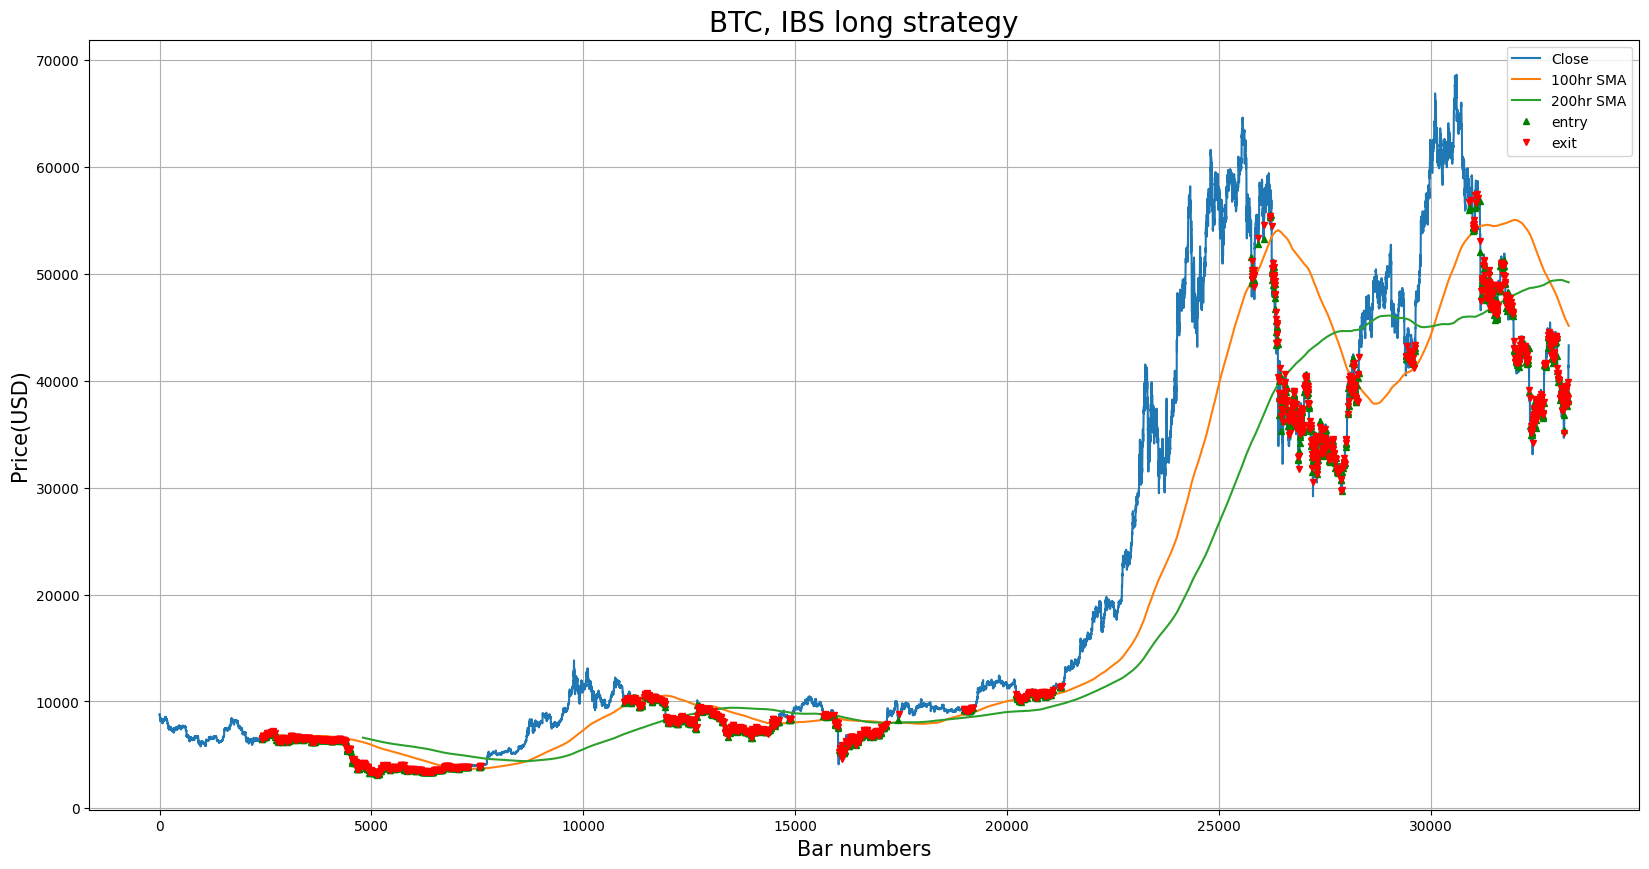

In [ ]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position']==1,:].index, df.loc[df['position']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position']==-1,:].index, df.loc[df['position']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

# Calculate the return

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position==1)|(df.position==-1),:]
df2['exit_close'] = df2['close'].shift(-1)
# calculate return
df2['ror'] = df2['exit_close']/df2['close']
df2['ror'] = df2['ror'].shift(1)
df2.loc[df2['position']==1,'ror'] = 1

<ipython-input-20-547d01e586eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close'] = df2['close'].shift(-1)
<ipython-input-20-547d01e586eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close']/df2['close']
<ipython-input-20-547d01e586eb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:
# copy df2 ror to df ror column
df['ror'] = df2['ror']
df['ror'].fillna(1,inplace=True)
# calculate accumulated ror
df['total'] = df['ror'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total'].iat[-1] / df['total'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  246.814 return(%)


In [ ]:
# calculate CAGR
total_profit = (df['total'].iat[-1] / df['total'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 38.78 MDD: -35.577


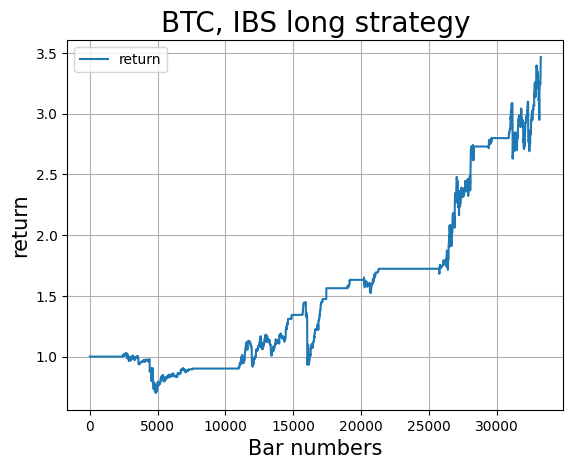

In [ ]:
# Let's plot return
plt.plot(df['total'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

Let's try basic IBS strategy

In [ ]:
df = df1.copy()

In [ ]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
# generate position column
# Create a new column called "position"
df["position_long"] = 0

# Set the value of "position" to 1 if "long" is True, and -1 if "short" is True
df.loc[df["short"] == True, "position_long"] = -1
df.loc[df["long"] == True, "position_long"] = 1

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_long"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_long'] = 0

    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_long"] = 0

# # time cut apply
# s = df['position_long']
# out = s.where(s.eq(1)).mul(-1).shift(24).fillna(s).astype('int')
# df['position_long'] = out


# # remove duplicated position signal again
# s_ = df['position_long'].mask(df['position_long']==0).ffill()
# df['position_long'] = df['position_long'].where(s_ != s_.shift(), 0)

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_long==1)|(df.position_long==-1),:].copy()
df2['exit_close_long'] = df2['close'].shift(1)
# calculate return
df2['ror'] = df2['close'] / df2['exit_close_long']
df2.loc[df2['position_long']==1,'ror'] = 1

In [ ]:
df['ror_long'] = df2['ror']
df['ror_long']= df['ror_long'].fillna(1)
# calculate accumulated ror
df['total_long'] = df['ror_long'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_long'].iat[-1] / df['total_long'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  1825.633 return(%)


In [ ]:
# calculate CAGR
total_profit = (df['total_long'].iat[-1] / df['total_long'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total_long'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 118.04 MDD: -22.087


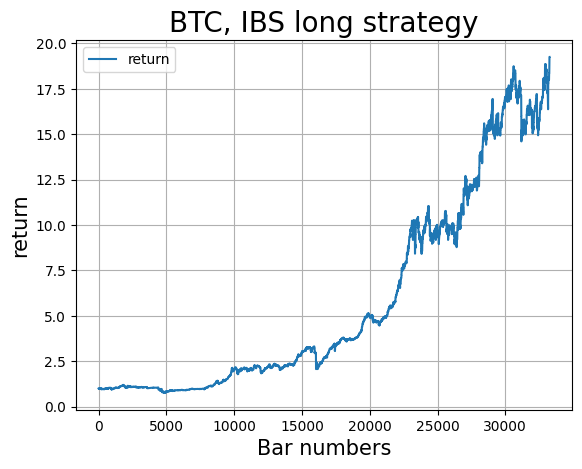

In [ ]:
# Let's plot return
plt.plot(df['total_long'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

Let's plot with price data

Text(0, 0.5, 'Close')

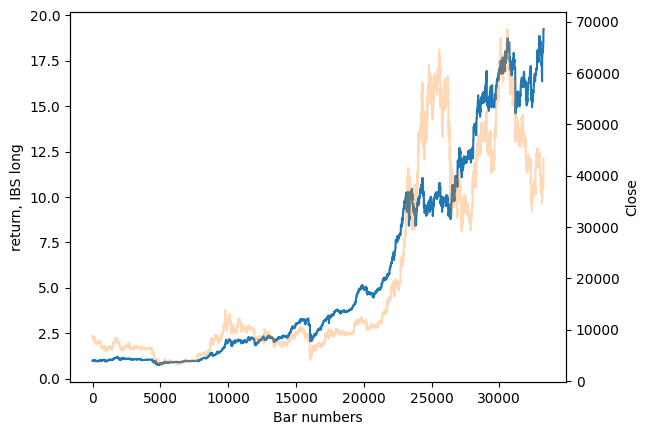

In [ ]:
# plot the price and return
fig, ax = plt.subplots()
df['total_long'].plot(ax=ax)
ax2 = df['close'].plot(ax=ax, secondary_y=True,alpha=.3)
ax.set_ylabel('return, IBS long')
ax2.set_ylabel('Close')

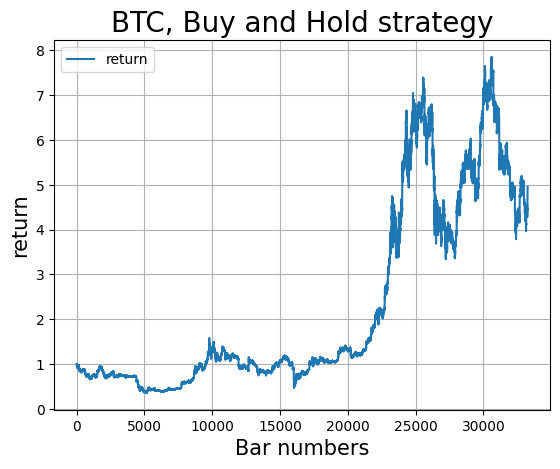

In [ ]:
# compare it with buy and hold strategy
df['tomorrow_close'] = df['close'].shift(-1)
df['ror_buyandhold'] = df['tomorrow_close']/df['close']
df['ror_buyandhold'].fillna(1,inplace=True)
df['total_buyandhold'] = df['ror_buyandhold'].cumprod()

# plot return
plt.plot(df['total_buyandhold'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, Buy and Hold strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_buyandhold'].iat[-1] / df['total_buyandhold'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  395.62 return(%)


In [ ]:
# calculate CAGR
total_profit = (df['total_buyandhold'].iat[-1] / df['total_buyandhold'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total_buyandhold'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 52.47 MDD: -51.75


# Let's test IBS short strategy

In [ ]:
# short 진입청산 컬럼 생성
df['entry_short'] = np.where((df['short']==True)&(df['short_con']==True), 1.0,0.0) # 진입신호
df['exit_short'] = np.where(df['long']==True, 1.0,0.0) # 청산신호

In [ ]:
# 포지션 보유 여부 컬럼 생성
df['position_short'] = df['entry_short'] - df['exit_short']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

## Visualize

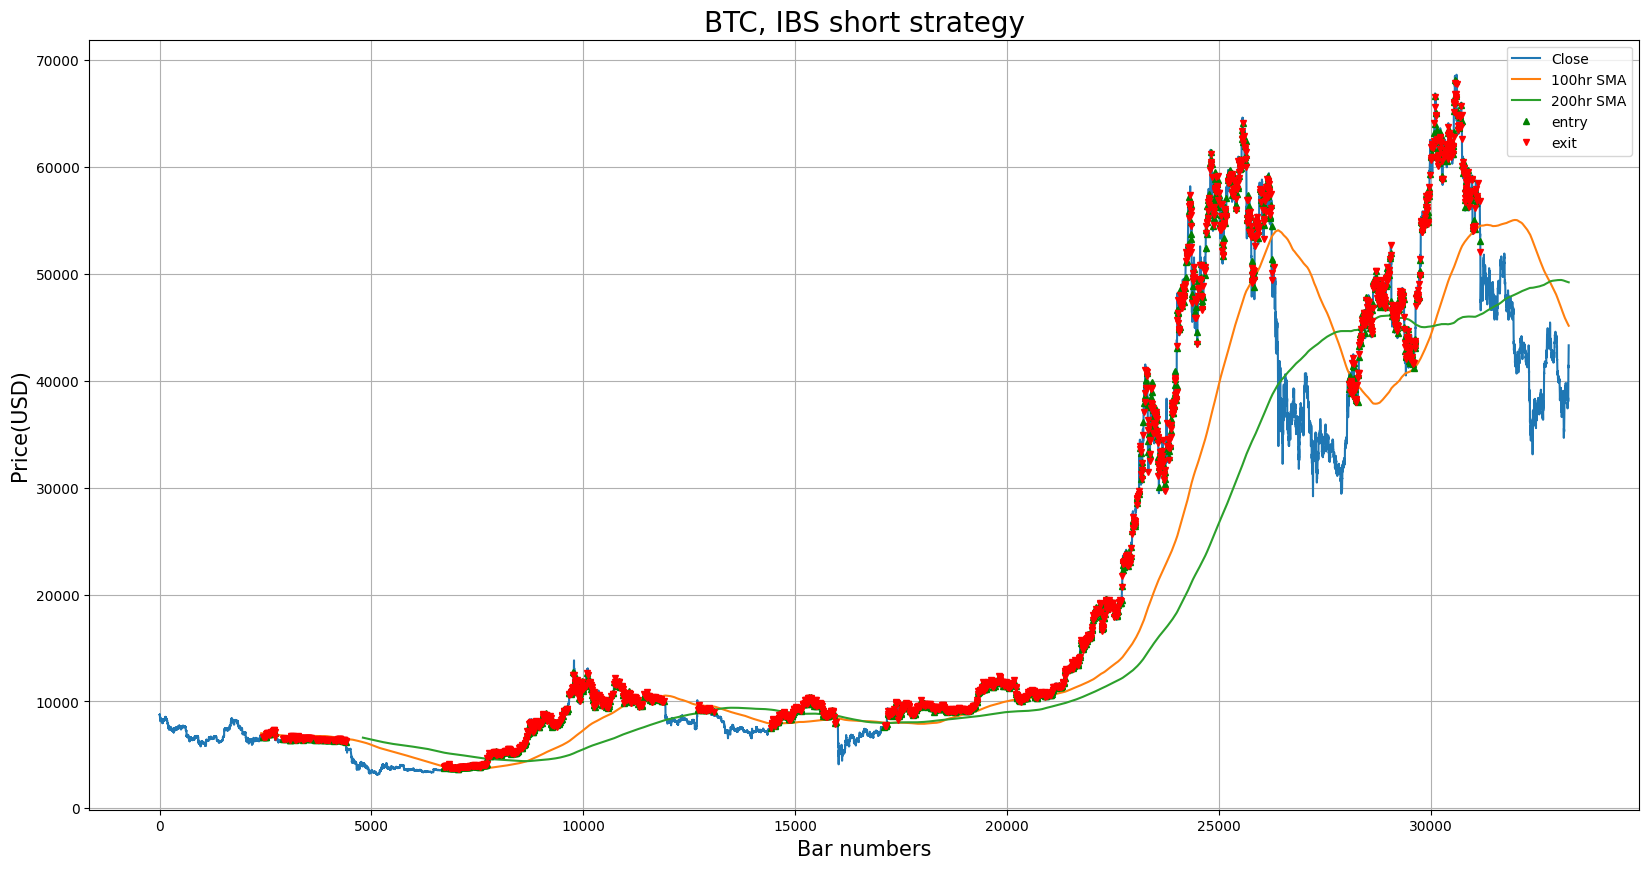

In [ ]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position_short']==1,:].index, df.loc[df['position_short']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position_short']==-1,:].index, df.loc[df['position_short']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

## calculate the return

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:]
df2['exit_close_short'] = df2['close'].shift(1)
# calculate return
df2['ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

<ipython-input-34-4e76530c87d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(1)
<ipython-input-34-4e76530c87d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close_short'] / df2['close']
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
df['ror_short'] = df2['ror']
df['ror_short'].fillna(1,inplace=True)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  -45.145 return(%)


## Let's twist the short strategy

* In bull market, short strategy can jeaperdize our account and give us huge loss

* We have several method to avoid this

 1) Minimize holding period
 
 2) Trade only in bear market (ex. close < 100SMA)

 3) Trade only in volatile market

In [ ]:
df = df1.copy()

### Minimize holding period

In [ ]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
# generate position column
# Create a new column called "position"
df["position_short"] = 0

# Set the value of "position" to 1 if "short" is True, and 0 if "long" is True
df.loc[df["short"] == True, "position_short"] = 1
df.loc[df["long"] == True, "position_short"] = -1

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0

    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

# time cut apply
s = df['position_short']
out = s.where(s.eq(1)).mul(-1).shift(24).fillna(s).astype('int')
df['position_short'] = out


# remove duplicated position signal again
s_ = df['position_short'].mask(df['position_short']==0).ffill()
df['position_short'] = df['position_short'].where(s_ != s_.shift(), 0)

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:].copy()
df2.loc[:,'exit_close_short'] = df2['close'].shift(1)
# calculate return
df2.loc[:,'ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

<ipython-input-39-4e76530c87d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(1)
<ipython-input-39-4e76530c87d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close_short'] / df2['close']


In [ ]:
df['ror_short'] = df2['ror']
df['ror_short']= df['ror_short'].fillna(1)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  55.222 return(%)


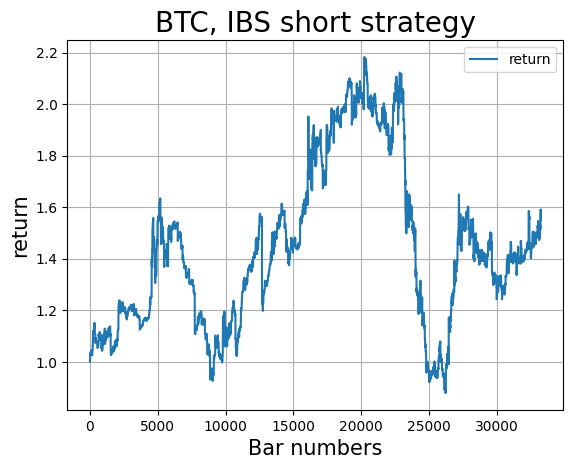

In [ ]:
# Let's plot return
plt.plot(df['total_short'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Trade only in bear market

* We can add condition to trade only in bear market

* First, we need to choose proper indicator to figure out the bear market

In [ ]:
# 50SMA column
df['50SMA'] = df['close'].rolling(1200).mean()

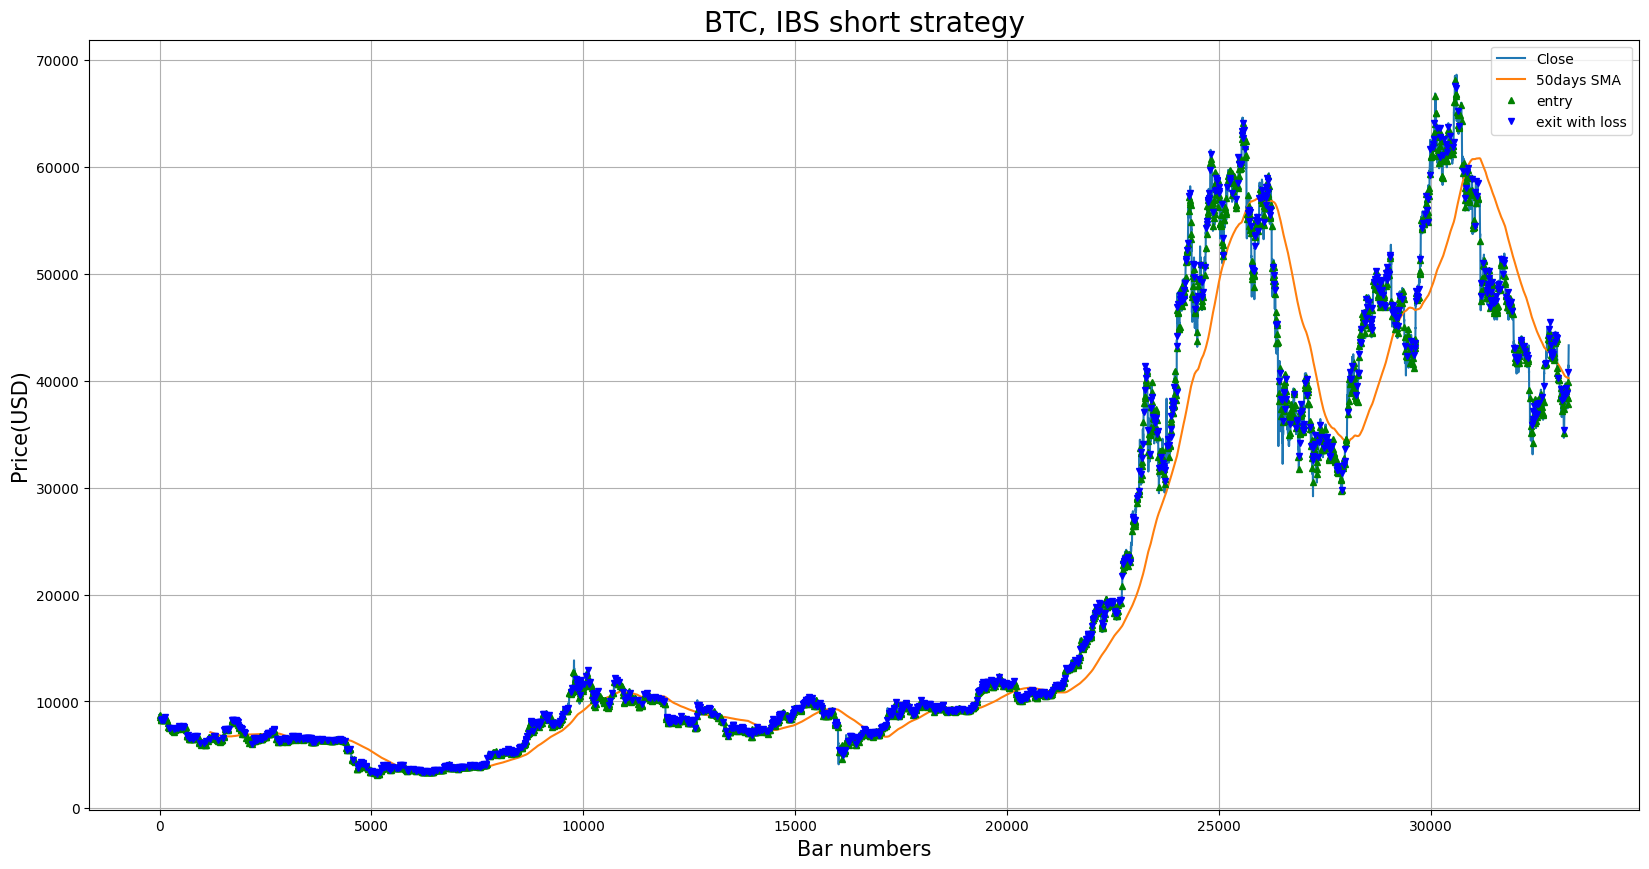

In [ ]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['50SMA'].plot(label='50days SMA')
# df['100SMA'].plot(label='100days SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position_short']==1,:].index, df.loc[df['position_short']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals with profit
# plt.plot(df.loc[(df['position_short']==-1) & (df['ror_short']>1),:].index, df.loc[(df['position_short']==-1.0) & (df['ror_short']>1),'close'], 'v', markersize = 5,  color = 'r', label = 'exit with profit')

# plot 'exit' signals with loss
plt.plot(df.loc[(df['position_short']==-1) & (df['ror_short']<1),:].index, df.loc[(df['position_short']==-1.0) & (df['ror_short']<1),'close'], 'v', markersize = 5,  color = 'b', label = 'exit with loss')

plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

Let's trade when the close < 50SMA

In [ ]:
df = df1.copy()
# 50SMA column
df['50SMA'] = df['close'].rolling(1200).mean()

In [ ]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
# generate position column
# Create a new column called "position"
df["position_short"] = 0

# Set the value of "position" to 1 if "short" is True, and 0 if "long" is True
df.loc[(df["short"] == True)&(df['close'] < df['50SMA']), "position_short"] = 1
df.loc[df["long"] == True, "position_short"] = -1

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0

    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

# time cut apply
s = df['position_short']
out = s.where(s.eq(1)).mul(-1).shift(24).fillna(s).astype('int')
df['position_short'] = out


# remove duplicated position signal again
s_ = df['position_short'].mask(df['position_short']==0).ffill()
df['position_short'] = df['position_short'].where(s_ != s_.shift(), 0)

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:].copy()
df2.loc[:,'exit_close_short'] = df2['close'].shift(1)
# calculate return
df2.loc[:,'ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

<ipython-input-57-4e76530c87d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(1)
<ipython-input-57-4e76530c87d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close_short'] / df2['close']
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
df['ror_short'] = df2['ror']
df['ror_short']= df['ror_short'].fillna(1)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  222.186 return(%)


In [ ]:
# calculate CAGR
total_profit = (df['total_short'].iat[-1] / df['total_short'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total_short'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 36.11 MDD: -23.125


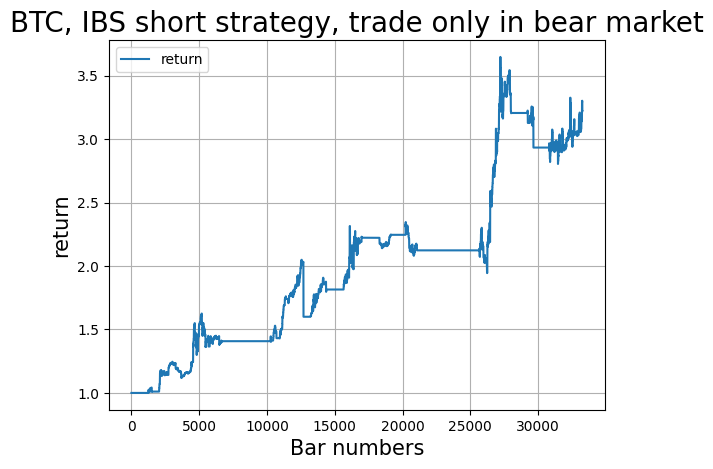

In [ ]:
# Let's plot return
plt.plot(df['total_short'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy, trade only in bear market', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Trade only in volatile market

Another Indicators that we can use to determine the market timing:

1. ATR(Average True Range)

2. Standard deviation

In [ ]:
df = df1.copy()

In [ ]:
# Let's calculate Standard deviation first
df['open_daily'] = df['open'].shift(24)
df['calculate'] = (df['open_daily']-df['close'])**2
df['daily_volatility'] = (df['calculate'].rolling(24).sum() / 24)**(1/2)
# generate last day std to compare with present std
df['daily_volatility2'] = df['daily_volatility'].shift(1)

In [ ]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
# generate position column
# Create a new column called "position"
df["position_short"] = 0

# Set the value of "position" to 1 if "short" is True, and 0 if "long" is True
df.loc[(df["short"] == True)&(df['daily_volatility']>df['daily_volatility2']), "position_short"] = 1
df.loc[df["long"] == True, "position_short"] = -1

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0

    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

# time cut apply
s = df['position_short']
out = s.where(s.eq(1)).mul(-1).shift(24).fillna(s).astype('int')
df['position_short'] = out


# remove duplicated position signal again
s_ = df['position_short'].mask(df['position_short']==0).ffill()
df['position_short'] = df['position_short'].where(s_ != s_.shift(), 0)

In [ ]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:].copy()
df2.loc[:,'exit_close_short'] = df2['close'].shift(1)
# calculate return
df2.loc[:,'ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

In [ ]:
df['ror_short'] = df2['ror']
df['ror_short']= df['ror_short'].fillna(1)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [ ]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  2.933 return(%)


In [ ]:
print('Trading counts:',(df['position_short']==1).sum())

Trading counts: 1870


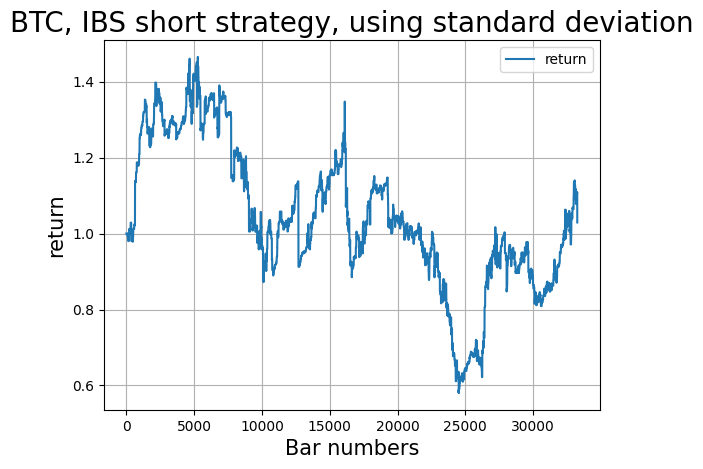

In [ ]:
# Let's plot return
plt.plot(df['total_short'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy, using standard deviation', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'Close')

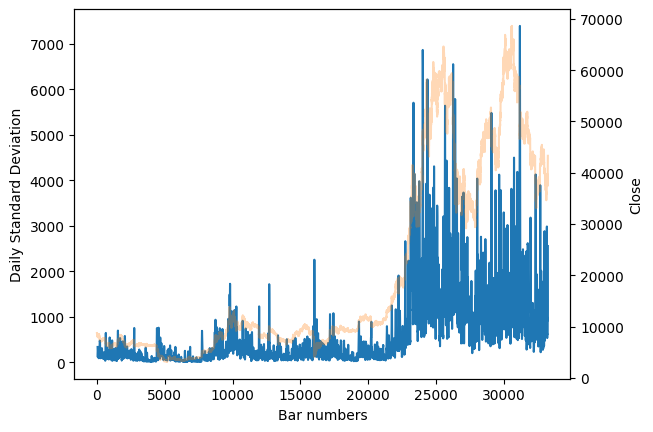

In [ ]:
# plot the daily standard deviation
fig, ax = plt.subplots()
df['daily_volatility'].plot(ax=ax)
ax2 = df['close'].plot(ax=ax, secondary_y=True,alpha=.3)
ax.set_ylabel('Daily Standard Deviation')
ax2.set_ylabel('Close')

# ***Conclusion***

* In long, it shows the best performance without any market timing or additional condition

* In short, we need to minimize the holding period and trade only in bear market

* Volatility is not relevance with performance in IBS strategy(further research would be needed)